## Heat Equation
#### Parameter estimation for Burgers' Equation (no source) using Gaussian processes (Backward Euler scheme)


#### Problem Setup

$u_t + u u_{x} + (\nu - e) u_{xx} = 0$

$u(x,t) = \frac{x}{1+t}$

$u_0(x) := u(x,0) = x$

$x \in [0, 1], t \in \{0, \tau \}$

Using the backward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} + u_n \frac{d}{dx}u_n - (\nu - e) \frac{d^2}{dx^2}u_n = 0$

and setting $u_n = \mu_n$ to deal with the non-linearity:

$u_n + \tau \mu_n \frac{d}{dx}u_n - \tau (\nu - e) \frac{d^2}{dx^2}u_n = u_{n-1}$


Consider $u_n$ to be a Gaussian processes.

$u_n \sim \mathcal{GP}(0, k_{uu}(x_i, x_j, \theta))$

And the linear operator:

$\mathcal{L}_x^\nu = \cdot + \tau \mu_n \frac{d}{dx}\cdot - \tau (\nu - e) \frac{d^2}{dx^2} \cdot$

so that

$\mathcal{L}_x^\nu u_n = u_{n-1}$

Problem at hand: estimate $\nu$ (should be $\nu = e$ in the end).

For the sake of simplicity, take $u := u_n$ and $f := u_{n-1}$.


#### step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

In [98]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [99]:
tau = 0.01
def get_simulated_data(tau):
    x = np.random.rand(20)
    y_u = x/(1+tau)
    y_f = x
    return (x, y_u,y_f)

(x, y_u, y_f) = get_simulated_data(tau)

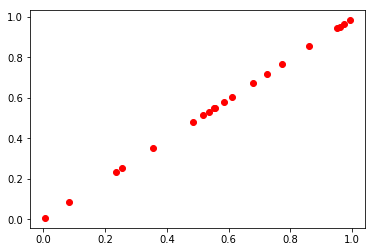

In [100]:
plt.plot(x, y_u, 'ro')
plt.show()

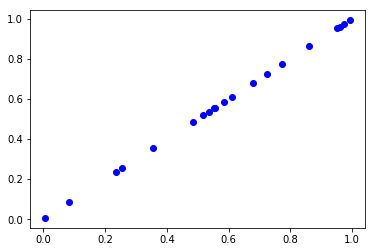

In [101]:
plt.plot(x, y_f, 'bo')
plt.show()

#### Step 2:Evaluate kernels

$k_{nn}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2}(x_i-x_j)^2)$

In [102]:
x_i, x_j, theta, mu_n, nu = sp.symbols('x_i x_j theta mu_n nu')
kuu_sym = theta*sp.exp(-1/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\nu \mathcal{L}_{x_j}^\nu k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\nu \left( k_{uu} + \tau \mu_n \frac{d}{dx_j}k_{uu} - \tau(\nu - e)\frac{d^2}{dx_j^2}k_{uu} \right) \\
 = k_{uu} + \tau \mu_n \frac{d}{dx_i}k_{uu} - \tau(\nu-e)\frac{d^2}{dx_i^2}k_{uu} + \tau\mu_n\frac{d}{dx_j}k_{uu} + \tau\mu_n\frac{d}{dx_i}\tau\mu_n\frac{d}{dx_j}k_{uu} - \tau(\nu - e)\frac{d^2}{dx_i^2}\tau\mu_n\frac{d}{dx_j}k_{uu} - \tau(\nu-e)\frac{d^2}{dx_j^2}k_{uu} - \tau\mu_n\frac{d}{dx_i}\tau(\nu-e)\frac{d^2}{dx_j^2}k_{uu} + \tau(\nu - e)\frac{d^2}{dx_i^2}\tau(\nu-e)\frac{d^2}{dx_j^2}k_{uu}$

In [103]:
kff_sym = kuu_sym \
        + tau*mu_n*(sp.diff(kuu_sym, x_i)) \
        - tau*(nu-np.e)*sp.diff(kuu_sym, x_i, x_i) \
        + tau*mu_n*sp.diff(kuu_sym, x_j) \
        + tau**2*mu_n**2*sp.diff(kuu_sym, x_i, x_j) \
        - tau**2*(nu-np.e)*mu_n*sp.diff(kuu_sym, x_j, x_i, x_i) \
        - tau*(nu-np.e)*sp.diff(kuu_sym, x_j, x_j) \
        - tau**2*mu_n*(nu-np.e)*sp.diff(kuu_sym, x_j, x_j, x_i) \
        + tau**2*(nu-np.e)**2*sp.diff(kuu_sym, x_j, x_j, x_i, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, mu_n, nu), kff_sym, "numpy")
def kff(x, theta, mu_n, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, mu_n, nu)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\nu k_{uu}(x_i, x_j; \theta) \\
= k_{uu} + \tau \mu_n \frac{d}{dx_i}k_{uu} - \tau(\nu - e) \frac{d^2}{dx_i^2}k_{uu}$

In [104]:
kfu_sym = kuu_sym + tau*mu_n*sp.diff(kuu_sym, x_i) - tau*(nu-np.e)*sp.diff(kuu_sym, x_i, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, mu_n, nu), kfu_sym, "numpy")
def kfu(x, theta, mu_n, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, mu_n, nu)
    return k

In [105]:
def kuf(x, theta, mu_n, nu):
    return kfu(x,theta,mu_n, nu).T

#### Step 3: Compute NLML

In [106]:
def nlml(params, x, y1, y2, s):
    theta_exp = np.exp(params[0]) # don't see why mu or nu must be positive
    K = np.block([
        [kuu(x, theta_exp) + s*np.identity(x.size), kuf(x, theta_exp, params[1], params[2])],
        [kfu(x, theta_exp, params[1], params[2]), kff(x, theta_exp, params[1], params[2]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [116]:
nlml((np.exp(-2.42), 0.53, np.e), x, y_u, y_f, 1e-6)


-205.47437331669116

Mapping w.r.t. theta:

-237.8898621048087

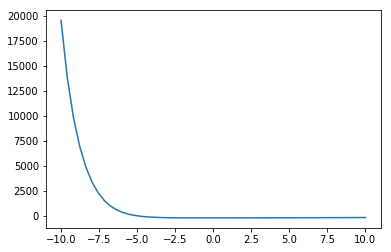

In [121]:
z = np.linspace(-10, 10)
z_out = [nlml((q, 0.53, 6.22), x, y_u, y_f, 1e-6) for q in z]
plt.plot(z, z_out)

nlml((0.53, 0.53, 6.22), x, y_u, y_f, 1e-6)

Mapping w.r.t. nu:

-205.86264037189855
-204.60485611567202
-209.62955661506413


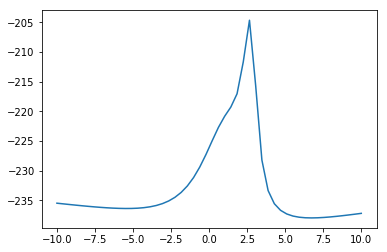

In [129]:
nlml((-2.4, 0.5, np.e) ,x ,y_u,y_f,1e-6) # mu should be roughly 0.5

z = np.linspace(-10, 10)
z_out = [nlml((0.53, 0.53, q), x, y_u, y_f, 1e-6) for q in z]
plt.plot(z, z_out)

# Relatively consistently we get the info, that vu = np.e is the maximizer, not the minimizer of the function:
print(nlml((0.53, 0.525, np.e - 0.2) ,x ,y_u,y_f,1e-6))
print(nlml((0.53, 0.525, np.e) ,x ,y_u,y_f,1e-6))
print(nlml((0.53, 0.525, np.e + 0.2) ,x ,y_u,y_f,1e-6))

# This is possibly hinting at a sign error somewhere

#### Step 4: Optimise hyperparameters

In [109]:
m = minimize(nlml, (np.random.rand(1), 0.5, np.e), args=(x, y_u, y_f, 1e-6), method="Nelder-Mead", options = {'maxiter' : 1000})

In [110]:
m.x[2]

6.2198395417518855

In [111]:
m

 final_simplex: (array([[-0.63551394,  0.52538897,  6.21983954],
       [-0.63551501,  0.52538874,  6.21974606],
       [-0.63553883,  0.5253878 ,  6.21976136],
       [-0.63553225,  0.52539213,  6.21980002]]), array([-239.48495151, -239.48495151, -239.48495151, -239.48495151]))
           fun: -239.48495151445627
       message: 'Optimization terminated successfully.'
          nfev: 163
           nit: 93
        status: 0
       success: True
             x: array([-0.63551394,  0.52538897,  6.21983954])